# Project Assignment:  Amazon products dataset

## Students

* Team: `9`
* Students: `Mateja Ilić & Miloš Novaković` (for the team submission)

## Part 2.1. Establishing a baseline

In order to see how our Graph-based learning algorithms compare to conventional Machine Learning models, we establish a baseline performance based on a simple Multi-Layer-Perceptron (MLP) architecture. To keep the comparison fair, we shall set the number of hidden layers and hidden dimensions to the same values in all Neural Network-like models, if possible.

In [ ]:
# downloading the necessary packages
!pip install torch-scatter torch-sparse torch-cluster torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 11.8 MB/s 
     |████████████████████████████████| 3.5 MB 32.1 MB/s 
     |████████████████████████████████| 2.5 MB 17.3 MB/s 
     |████████████████████████████████| 407 kB 10.6 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=c38c775eaf6d5fda939e4fc08864583d701dd8f46ef77f577c1ef026946ff404
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 12.9 MB/s 


In [ ]:
# importing the necessary packages and classes
import torch
import torch.nn.functional as F
from torch import nn
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.datasets import AmazonProducts
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    print("No GPU :(")
    device = 'cpu'

print(f"The device used is {device}.")

The device used is cuda.


In [ ]:
# upload your code to your Google Drive to import the data automatically
from google.colab import drive
drive.mount('/content/drive')
data_folder_path = '/content/drive/MyDrive/data/NML_Final_Project/'

Mounted at /content/drive


In [ ]:
# we load the dataset
dataset = AmazonProducts(root=data_folder_path)
data = dataset[0]
# in this case, we delete the graph data because it is not needed
del data.edge_index
print(data)

Data(x=[1569960, 200], y=[1569960, 107], train_mask=[1569960], val_mask=[1569960], test_mask=[1569960])


In [ ]:
num_nodes = data.x.shape[0]
num_features = data.x.shape[1]
num_classes = data.y.shape[1]
num_edges = data.num_edges
num_edge_features = data.num_edge_features

print(f"Feature X matrix \n {data.x}", end = "\n\n")
print(f"Feature X matrix shape \n {(data.x.shape[0], data.x.shape[1])}", end = "\n------------------------------------------------------------------\n")
print(f"Label Y matrix \n {data.y}", end = "\n\n")
print(f"Label Y matrix shape \n {(data.y.shape[0], data.y.shape[1])}", end = "\n------------------------------------------------------------------\n")
print(f"Number of nodes N = {num_nodes}", end = "\n\n")
print(f"Number of node features D = {num_features}", end = "\n\n")
print(f"Number of label classes C = {num_classes}", end = "\n\n")

Feature X matrix 
 tensor([[-0.1466,  0.2226, -0.3597,  ...,  0.1699,  0.8974,  1.6527],
        [-0.2805,  0.0190,  0.4301,  ..., -1.1758, -1.8365, -1.1693],
        [ 0.2554,  0.2519, -0.0291,  ...,  1.3751, -0.0735,  0.6262],
        ...,
        [-0.8121,  0.3626, -0.7781,  ...,  0.0639,  0.8645,  0.0389],
        [ 1.5977, -2.3989, -0.0569,  ..., -1.4413,  0.2966,  0.0985],
        [-0.1663,  0.0629, -0.0474,  ...,  0.1853, -0.1216, -0.9181]])

Feature X matrix shape 
 (1569960, 200)
------------------------------------------------------------------
Label Y matrix 
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Label Y matrix shape 
 (1569960, 107)
------------------------------------------------------------------
Number of nodes N = 1569960

Number of node features D = 200

Number of label classes C = 107



### Notes on the architecture and training:

If we want to label our nodes according to which of the 107 categories they belong to, what we get is a multi-class, multi-label, classification problem. For such problems, it is recommended to set the activation function of the output layer as the sigmoid function, which will return values in the (0,1) range. These values can then be interpreted as probabilities and compared to the known outputs in the training data using the binary cross-entropy loss funtction.

In [ ]:
# we define our MLP architecture with 1 hidden layer
hidden_dim1 = 512
hidden_dim2 = 512

class MLP(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.W1 = torch.nn.Linear(num_features, hidden_dim1)
        self.W2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.W3 = torch.nn.Linear(hidden_dim2, num_classes)
        if dropout:
            self.dropout1 = torch.nn.Dropout(p=0.1)
            self.dropout2 = torch.nn.Dropout(p=0.5)
            self.dropout3 = torch.nn.Dropout(p=0.5)

        self.dropout = dropout

    def forward(self, x):
        if self.dropout:
            x = self.dropout1(F.relu(self.W1(x)))
            x = self.dropout2(F.relu(self.W2(x)))
            x = self.dropout4(self.W3(x))
        else:
            x = F.relu(self.W1(x))
            x = F.relu(self.W2(x))
            x = self.W3(x)
        return torch.sigmoid(x) 

In [ ]:
def train(
    model: nn.Module,
    data: Data,
    optimizer: torch.optim.Optimizer,
    nb_epochs: int):
    
    # puts the model on the device and in the training state
    model.to(device)
    model.train()

    # container to save the losses for plotting
    losses = []

    for epoch in range(nb_epochs):
      optimizer.zero_grad()
      
      # forward pass of the model generates the prediction
      y_pred = model(data.x[data.train_mask].to(device))
      
      # calcualting the loss
      loss = F.binary_cross_entropy(input = y_pred,
                                    target = data.y[data.train_mask].to(device, dtype=torch.float))
      
      # after each calculation of loss function, save it to losses
      losses.append(loss.item())
      
      # backward pass (updating the gradients of the parameters of our model)
      loss.backward()
      
      # update of the parameters according to the chosen optimizer
      optimizer.step()

    return losses

def evaluate(
    model: nn.Module,
    metric: torchmetrics.Metric,
    data: Data,
    mask: torch.Tensor):
  
    model.eval()  # Deactivate dropout
    model.to(device)

    with torch.no_grad():
        # do a forward pass (i.e. a prediction) of the model on the features
        y_pred = model(data.x.to(device))

        # cast the float class prediction probabilites to discrete integer predictions
        y_pred = y_pred[mask]

        # get the ground truth labels
        y = data.y[mask].to(device)

        # update the petric that evaluates 
        metric.update(y_pred, y)
        #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    return metric.compute().item()

In [ ]:
# define whether we use dropout during training or not
dropout = False

# Define the Model that will be trained
model = MLP(dropout)

# define the the learning rate
lr = 1 * 1e-2

# define the optimization algorithm used in the train of the model
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# define the number of epochs in the training loop
nb_epochs = 700#50#100

# call the training function
start_training_time = time.time()
losses_ = train(model, data, optimizer, nb_epochs)
end_training_time = time.time()

# total training time
print(f"Total training time is {(end_training_time - start_training_time) // 60 : .2f} minutes and {(end_training_time - start_training_time) % 60 : .2f} seconds.")

Total training time is  15.00 minutes and  21.72 seconds.


Text(0, 0.5, 'Log Loss')

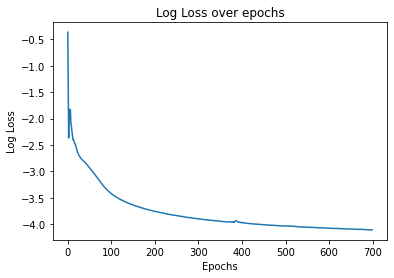

In [ ]:
# cast losses to the numpy array from the regular list
losses_ = np.array(losses_)

# plot both losses and cummulative mean of the losses
plt.plot(np.log(losses_))
plt.title("Log Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
#plt.xlim([nb_epochs//2, nb_epochs])

### Notes on the testing:

In order to test our results properly, we need to set the option `subset_accuracy=True`. That way, the torchmetrics Accuracy module will only count the output of our neural network as correct if all of the labels were assigned correctly, after thresholding the sigmoid outputs of our MLP. Otherwise, we would obtain a deceptively large accuracy, since the labeled outputs are inbalanced, with most of them being 0.

In [ ]:
metric = torchmetrics.Accuracy(num_classes=num_classes,
                               threshold=0.5,
                               subset_accuracy=True).to(device)

accuracy_train = evaluate(model = model,
                          metric = metric,
                          data = data,
                          mask = data.train_mask)

accuracy_val = evaluate(model = model,
                        metric = metric,
                        data = data,
                        mask = data.val_mask)

accuracy_test = evaluate(model = model,
                        metric = metric,
                        data = data,
                        mask = data.test_mask)

print("Train accuracy:", accuracy_train)
print("Val accuracy:", accuracy_val)
print("Test accuracy:", accuracy_test)

Train accuracy: 0.6426309943199158
Val accuracy: 0.6415952444076538
Test accuracy: 0.6393341422080994


### Results:

The MLP trains fairly quickly and has resulted in a surprisingly high accuracy rate, even though it doesn't explicitly exploit any of the underlying network structure. We suspect that this is the case because we have a lot of labeled data (80% of ~1.57M nodes) we can train on. This is also reflected in the fact that the MLP performs very similarly on the Validation and Test nodes as well, indicating that it managed to generalize as well as it architecture allowed it to. To see if we can do better than this, next we will try to use some GNN architectures that will try to embed the structure underlying our data explicitly before training an MLP classifier.